In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#Defining Machine parameters 
mach_mc = {"rs": 0.1729, "lq": 0.6986, "ld": 0.4347, "tmech":50.5, "psi_rm":0.9}
# mach_mc = {"rs": 0.009, "ld": 4.14, "lq": 4.21, "tmech":509.6, "psi_rm": 0.5}

# mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

# mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

# mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}

###  The Machine Parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

In [3]:
def mach_para(mach):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = mach["rs"]
    ld = mach['ld']
    lq = mach['lq']
#     ws = mach['ws']
#     sig= 1-(lh*lh)/(lr*ls)
#     kr=lh/lr
#     sigls=sig*ls
#     tr=lr/rr
#     rk=(rs+(kr)*(kr)*rr)
#     tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = mach['tmech']
    psi_rm = mach['psi_rm']
#     print("lh = {0:1.3f}".format(lh))
#     return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech
    return rs, ld, lq, tmech, psi_rm

In [4]:
mach_para(mach_mc)

(0.1729, 0.4347, 0.6986, 50.5, 0.9)

### PMSM Dynamics
#### Building the Dynamic Model of a PMSM in the d-q Coordinate
To model a PMSM, two state variables are chosen, which are $i_{s}$ and $\omega_{s}$. The $i_{s}$ can be further decomposed to $i_{sd}$, $i_{sq}$ in the permanant magnetic field since it is a complex space vector. The differential equations of these vectors are given as:

\begin{align}
\frac{di_{sd}}{d\tau}&= -\frac{r_{s}}{l_{d}}i_{sd} + \omega_{s} \frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d}\\
\frac{di_{sq}}{d\tau}&= - \omega_{s} \frac{l_d}{l_q}i_{sd} -\frac{r_{s}}{l_{q}}i_{sq}  - \omega_{s} \frac{\psi_{r,m}}{l_q} + \frac{v_{sq}}{l_q}\\
\frac{d\omega_s}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_L\right], m_e = \psi_{r,m}i_{sq}+(l_d-l_q)i_{sd}i_{sq}
\end{align}


In [5]:
#Induction machine 5x5 dynamic model 

def IM_dynstep(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
    ws = X[2] # w
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_imstep(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[1][0]*(-w_s*psi_rm+u2))
    dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
#     dx0dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*x2 + A[0][3]*x3*x4 + A[0][4]*x4 + B[0][0]*u1)
#     dx1dt = (A[1][0]*x0 + A[1][1]*x1 + A[1][2]*x2*x4 + A[1][3]*x3 + A[1][4]*x4 + B[1][0]*u2)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dx2dt = (A[2][0]*x0 + A[2][1]*x1 + A[2][2]*x2 + A[2][3]*x3*x4 + A[2][4]*x4 + 0)
#     dx3dt = (A[3][0]*x0 + A[3][1]*x1 + A[3][2]*x2*x4 + A[3][3]*x3 + A[3][4]*x4 + 0)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dwxdt = rate
    return [dx0_dt,dx1_dt,dx2_dt]


def mach_imstep(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
    a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
    a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
    a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
    b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
    c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0

    A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
    B = ([b11], [b21], [b31])
    C = ([c11, c22, c33])
    D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [6]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]
    

In [7]:
#Function for rotor angle integration 
# d\delta/dt = w

def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

In [8]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

In [9]:
# # testing block:
# TA,TB,TC,TD,tm = mach_imstep(mach_mc, params)
# print(TA, TB, TC, TD, tm)
# # print('kr = {0:3.3f}.'.format(kr))

## 1. System Dynamics without Control

In [10]:
#Setting up the simulaton for rotor model
# We will use for loop for simulation 
rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 20*2*np.pi
tstart = 0.0
delta_t = 0.01
n = 100000
# n2 = int(100*2*np.pi/0.01)
ws = -0.5
mL = 0.0
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usd = np.zeros(len(Tta))
usq = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),3))
# sol2 = np.zeros((len(Tta),2))
# FCangle = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))
eid = np.zeros(len(Tta))
eiq = np.zeros(len(Tta))
w = np.zeros(len(Tta))

# psird = np.zeros(len(Tta))
# psirq = np.zeros(len(Tta))

# # Initializing reference values for isd and isq:
# isdrefval = -0.1
# isdref = np.zeros(len(Tta))
# isqref = np.zeros(len(Tta))

# isqref1 = 0.0
# isqref2 = 0.8
# isqref3 = -0.35
# for ii in range(len(Tta)):
#     isdref[ii] = 0.0
#     if (Tta[ii]>=10*2*np.pi):
#         isqref[ii] = isqref3
#         isdref[ii] = -isdrefval
#     elif(Tta[ii]>=1*2*np.pi):
#         isqref[ii]=isqref2
#         isdref[ii] = isdrefval
#     else:
#         isqref[ii]=isqref1

me = np.zeros(len(Tta))
x0 = [0,0, ws] # isd, isq, ws
y0 = [1.0,0]

kpd = ld*1
Tid = 25.0e1

kpq = lq*2
Tiq = 25.0e1

Kparamsd = [kpd,Tid]
Kparamsq = [kpq,Tiq]

for ii in range(len(Tta)):
#     #Start controller after first step
#     if ii>=0:
#         eid[ii] = isdref[ii-1] - isd[ii-1]
#         PIed = [eid[ii],eid[ii-1]]
#         usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#         eiq[ii] = isqref[ii-1] - isq[ii-1]
#         PIeq = [eiq[ii],eiq[ii-1]]
#         usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#         usd[ii] = 0
#         usq[ii] =.0001
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
#     usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
#     usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]

    params = [usd[ii], usq[ii],w[ii], ws]
    sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
#     me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#     paramsw = [me[ii],0.0,tmech]
#     sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#     y0 = sol2a[-1]
#     sol2[ii] = sol2a[-1]
#     #Rotor angle using internal angle
#     FCangle[ii] = sol2[ii][1]
#     gamma[ii] = sol2[ii][1]
#     w[ii] = sol2[ii][0]
#     #using resolver output
# #     FCangle[ii] = sol2[ii]
#     cosdelta[ii] = np.cos(FCangle[ii])
#     sindelta[ii] = np.sin(FCangle[ii])
    #Coordinate transformation
    isd[ii] = sol1[ii][0]
    isq[ii] = sol1[ii][1]
#     #Convert stator coordinate current to field coordinates
#     isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
#     isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
#     psird[ii] = 1.0
#     psirq[ii]= 0.0

# for ii in range(len(Tta)):
#     if ws>=1.0:
#         a = 1.0
#     else: 
#         a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
# #     me[ii] = kr*(sol1[ii-1][2]*sol1[ii-1][1] - sol1[ii-1][3]*sol[ii-1][0]) - mL
#     params = [usa[ii], usb[ii],mL,ws]
#     sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#     sol1[ii]= sol1a[-1]
# #     display(sol1a[-1])
#     x0 = sol1a[-1]
# #     params2 = [sol1[ii][0], sol1[ii][1],sol1[ii][4]] # isa, isb, w
# #     sol2a = odeint(psirest_vr,y0,[0,delta_t], args = (params2,), atol = abserr, rtol= relerr)
# #     sol2[ii] = sol2a[-1]
# #     psircomp = np.complex(sol2[ii][0], sol2[ii][1])
# #     FCangle[ii] = np.arccos(sol2[ii][0]/np.abs(psircomp))
# #     cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
# #     sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
# #     #Coordinate transformation 
# #     #Convert stator coordinate current to field coordinates
# #     isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
# #     isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
# #     #Rotor flux in field coordinates
# #     psird[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
# #     psirq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]
# #     y0 = sol2a[-1]
    
# isd = sol1[:, 0]
# isq = sol1[:, 1]
# w = sol1[:, 2]
# psra = sol1[:, 2]
# psrb = sol1[:, 3]
# w = sol1[:,4]
# psiradash = sol2[:,0]
# psirbdash = sol2[:,1]

#rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
me = psi_rm*isq + (l_d-l_q)*isd*isq

Text(0, 0.5, 'me [p.u]')

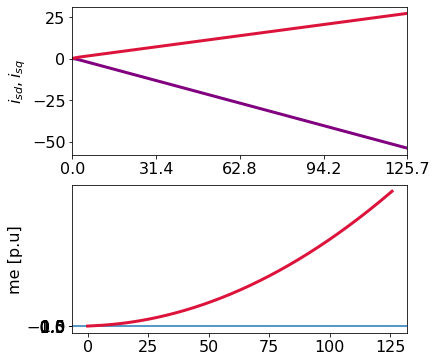

In [11]:
pl.figure(531, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'purple', lw = 3) 
pl.plot(Tta,isq ,'crimson' ,lw =3)
pl.xlim(0,tend)
pl.ylabel(r'$i_{sd}, i_{sq}$' )
pl.xticks(np.linspace(0,tend,5))
ax1 = pl.subplot(2,1,2)
ax1.axhline(0)
ax1.plot(Tta, me, 'crimson', lw =3)
ax1.set_yticks(np.linspace(-1.0,1.0,5))
ax1.set_ylabel('me [p.u]')
# t1w = np.pi*2*45
# t2w = np.pi*2*60
# pl.xlim(t1w,t2w)
# # pl.xlim(0,tend)
# pl.axhline(0.75)
# pl.axhline(-0.75)
# pl.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# pl.xticks(np.linspace(t1w,t2w,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
# pl.ylim(-1.0,1.0)
# ax1 = pl.subplot(2,1,2)
# ax1.plot(Tta, isd, 'tomato', lw =3, label = r'$i_{sd}$')
# ax1.plot(t1w+1,0.26,'o', c = 'tomato')
# pl.text(t1w+2,0.28, 'i = {0:1.3f}'.format(isd[-1]), fontsize = 12)
# ax1.plot(Tta,isq, 'purple', lw =3, label = r'$i_{sq}$')
# ax1.plot(Tta,psird, 'magenta', lw=2)
# ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
# ax1.set_xlabel(r'$\omega t$')
# ax2 = ax1.twinx()
# ax2.plot(Tta,FCangle, 'olive', lw =2)
# pl.rcParams['legend.fontsize']=12
# ax1.legend(loc = 'upper left')

#pl.axhline(1.0)
#pl.axhline(-1.0)

# t1w = np.pi*2*45
# t2w = np.pi*2*60
# ax1.set_xlim(t1w,t2w)
# ax1.set_xticks(np.linspace(t1w,t2w,5))
# ax1.set_yticks(np.linspace(0,1.0,6))
# ax1.set_ylim(-0.1,1.0)
# ax2.set_ylim(0,3.14)
# pl.savefig(dirfig + "FOCurrentsvst.pdf", bbox_inches = 'tight', transparent = True)

# pl.figure(533, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.text(psird[-1]-0.05,psirq[-1]+0.08, r'$\vec{\psi}_r$', fontsize=16 )
# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# pl.xlim(-0.01,1.0)
# pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# # pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# pl.savefig(dirfig + "FOXYvectors.pdf", bbox_inches = 'tight', transparent = True)


# pl.figure(536, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)

# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# # pl.xlim(0,1.0)
# # pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# # pl.savefig(dirfig + "FOXYvectorsFull.pdf", bbox_inches = 'tight', transparent = True)
# pl.show()
# print(isd[-1], isq[-1])

## 2. System Dynamics with Control

In [12]:
#Setting up the simulaton for rotor model
# We will use for loop for simulation 
rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
# ODE solver parameters
abserr = 1.0e-8
relerr = 1.0e-3

tend = 20*2*np.pi
tstart = 0.0
delta_t = 0.01
n = 100000
# n2 = int(100*2*np.pi/0.01)
ws = -0.5
mL = 0.0
Tta = np.arange(tstart, tend,delta_t)
# Tta = np.linspace(tstart, tend, n2)
#delta_t = Tta[1] - Tta[0]
usd = np.zeros(len(Tta))
usq = np.zeros(len(Tta))
sol1 = np.zeros((len(Tta),3))
# sol2 = np.zeros((len(Tta),2))
# FCangle = np.zeros(len(Tta))
# Field coordinate currents
cosdelta = np.zeros(len(Tta))
sindelta = np.zeros(len(Tta))
isd = np.zeros(len(Tta))
isq = np.zeros(len(Tta))
eid = np.zeros(len(Tta))
eiq = np.zeros(len(Tta))
w = np.zeros(len(Tta))

# psird = np.zeros(len(Tta))
# psirq = np.zeros(len(Tta))

# # Initializing reference values for isd and isq:
isdrefval = -0.1
isdref = np.zeros(len(Tta))
isqref = np.zeros(len(Tta))

isqref1 = 0.0
isqref2 = 0.8
isqref3 = -0.35
for ii in range(len(Tta)):
    isdref[ii] = 0.0
    if (Tta[ii]>=10*2*np.pi):
        isqref[ii] = isqref3
        isdref[ii] = -isdrefval
    elif(Tta[ii]>=1*2*np.pi):
        isqref[ii]=isqref2
        isdref[ii] = isdrefval
    else:
        isqref[ii]=isqref1

me = np.zeros(len(Tta))
x0 = [0,0, ws] # isd, isq, ws
y0 = [1.0,0]

kpd = ld*1
Tid = 25.0e1

kpq = lq*2
Tiq = 25.0e1

Kparamsd = [kpd,Tid]
Kparamsq = [kpq,Tiq]

for ii in range(len(Tta)):
    #Start controller after first step
    if ii>=0:
        eid[ii] = isdref[ii-1] - isd[ii-1]
        PIed = [eid[ii],eid[ii-1]]
        usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
        eiq[ii] = isqref[ii-1] - isq[ii-1]
        PIeq = [eiq[ii],eiq[ii-1]]
        usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)
#         usd[ii] = 0
#         usq[ii] =.0001
    if ws>=1.0:
        a = 1.0
    else: 
        a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
#     usa[ii] = usd[ii-1]*cosdelta[ii-1] - usq[ii-1]*sindelta[ii-1]
#     usb[ii] = usq[ii-1]*cosdelta[ii-1] + usd[ii-1]*sindelta[ii-1]

    params = [usd[ii], usq[ii],w[ii], ws]
    sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
    sol1[ii]= sol1a[-1]
#     display(sol1a[-1])
    x0 = sol1a[-1]
#     me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#     paramsw = [me[ii],0.0,tmech]
#     sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#     y0 = sol2a[-1]
#     sol2[ii] = sol2a[-1]
#     #Rotor angle using internal angle
#     FCangle[ii] = sol2[ii][1]
#     gamma[ii] = sol2[ii][1]
#     w[ii] = sol2[ii][0]
#     #using resolver output
# #     FCangle[ii] = sol2[ii]
#     cosdelta[ii] = np.cos(FCangle[ii])
#     sindelta[ii] = np.sin(FCangle[ii])
    #Coordinate transformation
    isd[ii] = sol1[ii][0]
    isq[ii] = sol1[ii][1]
#     #Convert stator coordinate current to field coordinates
#     isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
#     isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #Rotor flux in field coordinates Using estimator output as in practice
    #actual flux will not be available for measurement
#     psird[ii] = 1.0
#     psirq[ii]= 0.0

# for ii in range(len(Tta)):
#     if ws>=1.0:
#         a = 1.0
#     else: 
#         a = ws
#     usa[ii] = a*np.cos(ws*Tta[ii])
#     usb[ii] = a*np.sin(ws*Tta[ii])
# #     me[ii] = kr*(sol1[ii-1][2]*sol1[ii-1][1] - sol1[ii-1][3]*sol[ii-1][0]) - mL
#     params = [usa[ii], usb[ii],mL,ws]
#     sol1a = odeint(IM_dynstep,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#     sol1[ii]= sol1a[-1]
# #     display(sol1a[-1])
#     x0 = sol1a[-1]
# #     params2 = [sol1[ii][0], sol1[ii][1],sol1[ii][4]] # isa, isb, w
# #     sol2a = odeint(psirest_vr,y0,[0,delta_t], args = (params2,), atol = abserr, rtol= relerr)
# #     sol2[ii] = sol2a[-1]
# #     psircomp = np.complex(sol2[ii][0], sol2[ii][1])
# #     FCangle[ii] = np.arccos(sol2[ii][0]/np.abs(psircomp))
# #     cosdelta[ii] = sol2[ii][0]/np.abs(psircomp)
# #     sindelta[ii] = sol2[ii][1]/np.abs(psircomp)
# #     #Coordinate transformation 
# #     #Convert stator coordinate current to field coordinates
# #     isd[ii] = sol1[ii][0]*cosdelta[ii] + sol1[ii][1]*sindelta[ii]
# #     isq[ii] = sol1[ii][1]*cosdelta[ii] - sol1[ii][0]*sindelta[ii]
# #     #Rotor flux in field coordinates
# #     psird[ii] = sol2[ii][0]*cosdelta[ii] + sol2[ii][1]*sindelta[ii]
# #     psirq[ii] = sol2[ii][1]*cosdelta[ii] - sol2[ii][0]*sindelta[ii]
# #     y0 = sol2a[-1]
    
# isd = sol1[:, 0]
# isq = sol1[:, 1]
# w = sol1[:, 2]
# psra = sol1[:, 2]
# psrb = sol1[:, 3]
# w = sol1[:,4]
# psiradash = sol2[:,0]
# psirbdash = sol2[:,1]

#rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
me = psi_rm*isq + (l_d-l_q)*isd*isq

In [13]:
print(isd)
print(isq)
print(me)

[0.00100436 0.00097342 0.00089229 ... 0.10000011 0.10000011 0.10000011]
[-0.00058619  0.00581419  0.01203562 ... -0.34999994 -0.34999994
 -0.34999994]
[-0.00052742  0.00523128  0.01082922 ... -0.30576344 -0.30576344
 -0.30576344]


Text(0, 0.5, 'me [p.u]')

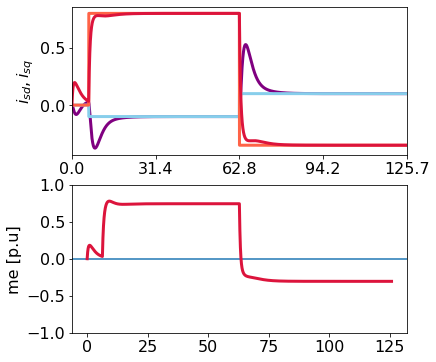

In [14]:
pl.figure(531, figsize = (6,6))
pl.rc('font', size = 16)
pl.subplot(2,1,1)
pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3) 
pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =3)
pl.xlim(0,tend)
pl.ylabel(r'$i_{sd}, i_{sq}$' )
pl.xticks(np.linspace(0,tend,5))
ax1 = pl.subplot(2,1,2)
ax1.axhline(0)
ax1.plot(Tta, me, 'crimson', lw =3)
ax1.set_yticks(np.linspace(-1.0,1.0,5))
ax1.set_ylabel('me [p.u]')
# t1w = np.pi*2*45
# t2w = np.pi*2*60
# pl.xlim(t1w,t2w)
# # pl.xlim(0,tend)
# pl.axhline(0.75)
# pl.axhline(-0.75)
# pl.ylabel(r'$i_{s\alpha}, \i_{s\beta}$' )
# pl.xticks(np.linspace(t1w,t2w,5))
# pl.yticks(np.linspace(-1.0,1.0,5))
# pl.ylim(-1.0,1.0)
# ax1 = pl.subplot(2,1,2)
# ax1.plot(Tta, isd, 'tomato', lw =3, label = r'$i_{sd}$')
# ax1.plot(t1w+1,0.26,'o', c = 'tomato')
# pl.text(t1w+2,0.28, 'i = {0:1.3f}'.format(isd[-1]), fontsize = 12)
# ax1.plot(Tta,isq, 'purple', lw =3, label = r'$i_{sq}$')
# ax1.plot(Tta,psird, 'magenta', lw=2)
# ax1.set_ylabel(r'$i_{sd}, \i_{sq}$' )
# ax1.set_xlabel(r'$\omega t$')
# ax2 = ax1.twinx()
# ax2.plot(Tta,FCangle, 'olive', lw =2)
# pl.rcParams['legend.fontsize']=12
# ax1.legend(loc = 'upper left')

#pl.axhline(1.0)
#pl.axhline(-1.0)

# t1w = np.pi*2*45
# t2w = np.pi*2*60
# ax1.set_xlim(t1w,t2w)
# ax1.set_xticks(np.linspace(t1w,t2w,5))
# ax1.set_yticks(np.linspace(0,1.0,6))
# ax1.set_ylim(-0.1,1.0)
# ax2.set_ylim(0,3.14)
# pl.savefig(dirfig + "FOCurrentsvst.pdf", bbox_inches = 'tight', transparent = True)

# pl.figure(533, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.text(psird[-1]-0.05,psirq[-1]+0.08, r'$\vec{\psi}_r$', fontsize=16 )
# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# pl.xlim(-0.01,1.0)
# pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# # pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# pl.savefig(dirfig + "FOXYvectors.pdf", bbox_inches = 'tight', transparent = True)


# pl.figure(536, figsize = (4,4))
# pl.rc('font', size = 16)
# pl.rcParams['axes.titlesize']=14
# pl.plot(isd,isq,'crimson', lw =2, label = 'Field currents')
# # pl.plot(psird, psirq, 'blue', lw =4 , label = "actual")
# # pl.axhline(0)
# pl.axvline(0)
# pl.arrow(0,0,psird[-1],psirq[-1], fc = 'magenta', ec = 'magenta',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],isq[-1], fc = 'crimson', ec = 'crimson',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(0,0,isd[-1],0, fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)
# pl.arrow(isd[-1],0,0,isq[-1], fc = 'coral', ec = 'coral',  head_width = 0.05\
#          ,length_includes_head = True, lw =3)

# pl.xlabel(r'$d}$')
# pl.ylabel(r'$q$')
# # pl.xlim(0,1.0)
# # pl.ylim(-0.02,1.0)
# # pl.xticks(np.linspace(-1.0,1.0,5))
# pl.axis('equal')
# pl.rcParams['legend.fontsize']=9
# # pl.legend(loc = 'lower left', bbox_to_anchor = (0.8,0))
# pl.title('Field Coordinates')
# # pl.savefig(dirfig + "FOXYvectorsFull.pdf", bbox_inches = 'tight', transparent = True)
# pl.show()
# print(isd[-1], isq[-1])

## 3. System with Increasing Speed $\omega_s$

In [15]:
#Induction machine 5x5 dynamic model 

def PMSM_dynStep2By2(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_PMSMStep2By2(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1+ B[1][0]*(-w_s*psi_rm+u2))
#     dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)

    return [dx0_dt,dx1_dt]


def mach_PMSMStep2By2(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
#     a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
#     a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
#     a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
#     b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
#     c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0
    A = ([a11,a12],[a21,a22],[a31,a32])
    B = ([b11], [b21])
    C = ([c11, c22])
    D= ([0,0],[0,0])
#     A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
#     B = ([b11], [b21], [b31])
#     C = ([c11, c22, c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [16]:
# def simulateSpeedingUpWithAcceleration(a):
#     #Setting up the simulaton for rotor model
#     # We will use for loop for simulation 
#     rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
#     tend = 20*2*np.pi
#     tstart = 0.0
#     delta_t = 0.01
#     Tta = np.arange(tstart, tend,delta_t)
#     # ODE solver parameters
#     abserr = 1.0e-8
#     relerr = 1.0e-3
    
#     n = 100000
# #     n2 = int(100*2*np.pi/0.01)
#     # ws = -0.5
#     ws = np.zeros(len(Tta))
#     # Initializing ws:
# #     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
#     mL = 0.0
#     # Tta = np.linspace(tstart, tend, n2)
#     #delta_t = Tta[1] - Tta[0]
#     usd = np.zeros(len(Tta))
#     usq = np.zeros(len(Tta))
#     sol1 = np.zeros((len(Tta),2))
#     # sol2 = np.zeros((len(Tta),2))
#     # FCangle = np.zeros(len(Tta))
#     # Field coordinate currents
#     cosdelta = np.zeros(len(Tta))
#     sindelta = np.zeros(len(Tta))
#     isd = np.zeros(len(Tta))
#     isq = np.zeros(len(Tta))
#     eid = np.zeros(len(Tta))
#     eiq = np.zeros(len(Tta))
#     w = np.zeros(len(Tta))

#     # psird = np.zeros(len(Tta))
#     # psirq = np.zeros(len(Tta))

#     # # Initializing reference values for isd and isq:
#     isdrefval = -0.1
#     isdref = np.zeros(len(Tta))
#     isqref = np.zeros(len(Tta))

#     isqref1 = 0.0
#     isqref2 = 0.8
#     isqref3 = -0.35
#     for ii in range(len(Tta)):
#         isdref[ii] = 0.0
#         if (Tta[ii]>=10*2*np.pi):
#             isqref[ii] = isqref3
#             isdref[ii] = -isdrefval
#         elif(Tta[ii]>=1*2*np.pi):
#             isqref[ii]=isqref2
#             isdref[ii] = isdrefval
#         else:
#             isqref[ii]=isqref1

#     me = np.zeros(len(Tta))
#     x0 = [0,0] # isd, isq, ws
#     y0 = [1.0,0]

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]

#     for ii in range(len(Tta)):
#         #Start controller after first step
#         if ii>=0:
#             eid[ii] = isdref[ii-1] - isd[ii-1]
#             PIed = [eid[ii],eid[ii-1]]
#             usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#             eiq[ii] = isqref[ii-1] - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

#         # solve for the state variables: isd, isq
#         params = [usd[ii], usq[ii],w[ii], ws[ii]]
#         sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#         sol1[ii]= sol1a[-1]
#         x0 = sol1a[-1]
#         isd[ii] = sol1[ii][0]
#         isq[ii] = sol1[ii][1]


#     #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
#     rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
#     return Tta, ws, me, isd, isq

In [17]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]

In [79]:
def simulateSpeedingUpWithAcceleration(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3):
    #Setting up the simulaton for rotor model
    # We will use for loop for simulation 
    rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
    tend = 20*2*np.pi
    tstart = 0.0
    delta_t = 0.01
    Tta = np.arange(tstart, tend,delta_t)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-3
    
    n = 100000
#     n2 = int(100*2*np.pi/0.01)
    # ws = -0.5
    ws = -0.5
    # Initializing ws:
#     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
    mL = 0.0
    # Tta = np.linspace(tstart, tend, n2)
    #delta_t = Tta[1] - Tta[0]
    usd = np.zeros(len(Tta))
    usq = np.zeros(len(Tta))
    sol1 = np.zeros((len(Tta),2))
    sol2 = np.zeros((len(Tta),2))
    FCangle = np.zeros(len(Tta))
    gamma = np.zeros(len(Tta)) # rotor angle
    # Field coordinate currents
    cosdelta = np.zeros(len(Tta))
    sindelta = np.zeros(len(Tta))
    isd = np.zeros(len(Tta))
    isq = np.zeros(len(Tta))
    eid = np.zeros(len(Tta))
    eiq = np.zeros(len(Tta))
    w = np.zeros(len(Tta))

    # psird = np.zeros(len(Tta))
    # psirq = np.zeros(len(Tta))

    # # Initializing reference values for isd and isq:
    isdrefval = -0.1
    isdref = np.zeros(len(Tta))
    isqref = np.zeros(len(Tta))

#     isqref1 = 0.0
#     isqref2 = 0.8
#     isqref3 = -0.35
    print("---")
    print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
    print("---")
    for ii in range(0, len(Tta)):
        print(Tta[ii])
        if(Tta[ii] >= 0 and Tta[ii] <= 2*np.pi):
            isdref[ii] = 0.0
            isqref[ii] = 0.0
        elif (Tta[ii] >= 2*np.pi and Tta[ii] <= 10*np.pi):
            isdref[ii] = float(isdRef1)
            isqref[ii] = float(isqRef1)
        elif(Tta[ii] >= 10*np.pi and Tta[ii] <= 30*np.pi):
            isdref[ii] = float(isdRef2)
            isqref[ii] = float(isqRef2)
        else:
            print(isdRef3)
            isdref[ii] = float(isdRef3)
            print(isdref[ii])
            isqref[ii] = float(isqRef3)
        print("-v-")
        print(isdRef3)
        print(float(isdRef3))
        print("-^-")
        print(isqRef2)
        print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
#         print(isdref[ii])
#         print(isqref[ii])

    me = np.zeros(len(Tta))
    x0 = [0,0] # isd, isq, ws
    y0 = [0,0] # w, angle

    kpd = ld*1
    Tid = 25.0e1

    kpq = lq*2
    Tiq = 25.0e1

    Kparamsd = [kpd,Tid]
    Kparamsq = [kpq,Tiq]

    for ii in range(0, len(Tta)):      
        #Start controller after first step
        if ii>=0:
            eid[ii] = isdref[ii-1] - isd[ii-1]
            PIed = [eid[ii],eid[ii-1]]
            usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
            eiq[ii] = isqref[ii-1] - isq[ii-1]
            PIeq = [eiq[ii],eiq[ii-1]]
            usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

        # solve for the state variables: isd, isq
        params = [usd[ii], usq[ii],w[ii], ws]
        sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
        sol1[ii]= sol1a[-1]
        x0 = sol1a[-1]
        isd[ii] = sol1[ii][0]
        isq[ii] = sol1[ii][1]
        # solve for w:
        me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
        paramsw = [me[ii],0.0,tmech]
        sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
        y0 = sol2a[-1]
        sol2[ii] = sol2a[-1]
        FCangle[ii] = sol2[ii][1]
        gamma[ii] = sol2[ii][1]
        w[ii] = sol2[ii][0]
        #Convert field coordinate stator to field coordinates
#         isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
#         isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
    #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
    return Tta, w, me, isd, isq, isdref, isqref

In [84]:
# def simulateSpeedingUpWithAcceleration(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3):
#     #Setting up the simulaton for rotor model
#     # We will use for loop for simulation 
#     rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
#     tend = 20*2*np.pi
#     tstart = 0.0
#     delta_t = 0.01
#     Tta = np.arange(tstart, tend,delta_t)
#     # ODE solver parameters
#     abserr = 1.0e-8
#     relerr = 1.0e-3
    
#     n = 100000
# #     n2 = int(100*2*np.pi/0.01)
#     # ws = -0.5
#     ws = -0.5
#     # Initializing ws:
# #     a = 0.0001 # angular acceleration
# #     for i in range(1, len(Tta)):
# #         new_ws = ws[i-1]+a
# #         if(new_ws > 1):
# #             ws[i] = 1
# #         else:
# #             ws[i] = new_ws
#     mL = 0.0
#     # Tta = np.linspace(tstart, tend, n2)
#     #delta_t = Tta[1] - Tta[0]
#     usd = np.zeros(len(Tta))
#     usq = np.zeros(len(Tta))
#     sol1 = np.zeros((len(Tta),2))
#     sol2 = np.zeros((len(Tta),2))
#     FCangle = np.zeros(len(Tta))
#     gamma = np.zeros(len(Tta)) # rotor angle
#     # Field coordinate currents
#     cosdelta = np.zeros(len(Tta))
#     sindelta = np.zeros(len(Tta))
#     isd = np.zeros(len(Tta))
#     isq = np.zeros(len(Tta))
#     eid = np.zeros(len(Tta))
#     eiq = np.zeros(len(Tta))
#     w = np.zeros(len(Tta))

#     # psird = np.zeros(len(Tta))
#     # psirq = np.zeros(len(Tta))

#     # # Initializing reference values for isd and isq:
#     isdrefval = -0.1
#     isdref = np.zeros(len(Tta))
#     isqref = np.zeros(len(Tta))

# #     isqref1 = 0.0
# #     isqref2 = 0.8
# #     isqref3 = -0.35
# #     print("---")
# #     print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
# #     print("---")
#     for ii in range(0, len(Tta)):
# #         print(Tta[ii])
#         if(Tta[ii] >= 0 and Tta[ii] <= 2*np.pi):
#             isdref[ii] = 0.0
#             isqref[ii] = 0.0
#         elif (Tta[ii] >= 2*np.pi and Tta[ii] <= 10*np.pi):
#             isdref[ii] = float(isdRef1)
#             isqref[ii] = float(isqRef1)
#         elif(Tta[ii] >= 10*np.pi and Tta[ii] <= 30*np.pi):
#             isdref[ii] = float(isdRef2)
#             isqref[ii] = float(isqRef2)
#         else:
# #             print(isdRef3)
#             isdref[ii] = float(isdRef3)
# #             print(isdref[ii])
#             isqref[ii] = float(isqRef3)
# #         print("-v-")
# #         print(isdRef3)
# #         print(float(isdRef3))
# #         print("-^-")
# #         print(isqRef2)
# #         print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
# #         print(isdref[ii])
# #         print(isqref[ii])

#     me = np.zeros(len(Tta))
#     x0 = [0,0] # isd, isq, ws
#     y0 = [0,0] # w, angle

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]
#     flag = 0

# #     for ii in range(0, len(Tta))
#     while(ii < len(Tta)):      
#         #Start controller after first step
#         if ii>=0:
#             eid[ii] = isdref[ii-1] - isd[ii-1]
#             PIed = [eid[ii],eid[ii-1]]
#             usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#             eiq[ii] = isqref[ii-1] - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

#         # solve for the state variables: isd, isq
#         params = [usd[ii], usq[ii],w[ii], ws]
#         sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#         sol1[ii]= sol1a[-1]
#         x0 = sol1a[-1]
#         isd[ii] = sol1[ii][0]
#         isq[ii] = sol1[ii][1]
#         # solve for w:
#         me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
#         paramsw = [me[ii],0.0,tmech]
#         sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
#         y0 = sol2a[-1]
#         sol2[ii] = sol2a[-1]
#         FCangle[ii] = sol2[ii][1]
#         gamma[ii] = sol2[ii][1]
#         w[ii] = sol2[ii][0]
#         TtaEnd = Tta[ii]
#         print("w:")
#         print(w)
# #         while(w[ii] > 0 and flag == 0):
# #             isdref = np.concatenate((np.array([1]),isdref), axis = None)
# #             isqref = np.concatenate((np.array([-0.35]),isqref), axis = None)
            
# #             ii+=1
# #             # solve for the state variables: isd, isq
# #             params = [usd[ii], usq[ii],w[ii], ws]
# #             sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
# #             sol1[ii]= sol1a[-1]
# #             x0 = sol1a[-1]
# #             isd[ii] = sol1[ii][0]
# #             isq[ii] = sol1[ii][1]
# #             # solve for w:
# #             me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
# #             paramsw = [me[ii],0.0,tmech]
# #             sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
# #             y0 = sol2a[-1]
# #             sol2[ii] = sol2a[-1]
# #             FCangle[ii] = sol2[ii][1]
# #             gamma[ii] = sol2[ii][1]
# #             w[ii] = sol2[ii][0]
# #             TtaEnd = Tta[ii]
# #             if(w[ii] <= 0):
# #                 flag = 1
# #                 break
#         ii += 1
#         #Convert field coordinate stator to field coordinates
# #         isa[ii] = sol1[ii][0]*cosdelta[ii] - sol1[ii][1]*sindelta[ii]
# #         isb[ii] = sol1[ii][1]*cosdelta[ii] + sol1[ii][0]*sindelta[ii]
#     #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
# #     TtaReturn = Tta[0: int(TtaEnd)]
#     rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
# #     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
#     return Tta, w, me, isd, isq, isdref, isqref

In [81]:
# import matplotlib.pyplot as pl
# %matplotlib inline
def plotDynamicForSpeedingUp(Tta, w1, me1, isd1, isq1, isdref, isqref):
    pl.figure(531, figsize = (6,6))
    pl.rc('font', size = 16)
    # plot the isd and isq
    pl.subplot(2,1,1)
#     pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3)
    pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =3)
#     pl.plot(Tta,  isdref,'skyblue', lw=3)
#     pl.plot(Tta, isqref ,'crimson' ,lw =3)
    pl.xlim(0,tend)
    pl.ylabel(r'$isd, isq$' )
    pl.xticks(np.linspace(0,tend,5))
    # # plot isd and isq:
    # pl.subplot(2,1,2)
    # pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3) 
    # pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =3)
    # pl.xlim(0,tend)
    # pl.ylabel(r'$i_{sd}, i_{sq}$' )
    # pl.xticks(np.linspace(0,tend,5))
    # plot me
    # plot torque and speed:
    ax1 = pl.subplot(2,1,2)
    ax1.axhline(0)
    ax1.plot(Tta, me1, 'crimson', lw =3)
    ax1.set_yticks(np.linspace(-1.0,1.0,5))
    ax1.set_ylabel('me [p.u]')
    ax2 = ax1.twinx()
    ax2.set_ylabel('$\omega$')
    ax2.plot(Tta,w, 'peru', lw =3)

In [82]:
def calculateIsdIsqRefs(ml, a, isq):
    rs,ld,lq, tmech, psirm = mach_para(mach_mc)
    isqOrig = isq
    while((psi_rm+(ld-lq)*isq) == 0 and isq >= -1 and isq <= 1):
        isq -= 0.001
    if((psi_rm+(ld-lq)*isq) != 0):
        isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
    else:
        isq = isqOrig
        while((psi_rm+(ld-lq)*isq) == 0 and isq >= -1 and isq <= 1):
            isq += 0.001
        if((psi_rm+(ld-lq)*isq) != 0):
            isd = tmech*(a+ml)/(psi_rm+(ld-lq)*isq)
    if((psi_rm+(ld-lq)*isq) == 0):
        isd, isq = -2, -2 # No solotion
    return isd, isq

2.2899840280541937 -0.35
0.0 -0.35
-2.2899840280541937 -0.35
2.2899840280541937 0.0 -2.2899840280541937 -0.35 -0.35 -0.35
---
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
---
0.0
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
0.01
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
0.02
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
0.03
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
0.04
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
0.05
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
0.06
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
0.07
-v-
-2.2899840280541937
-2.28998402805419

-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.12
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.13
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.14
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.15
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.16
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.17
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.18
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.19
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
2.2
-v-
-2.2899

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.7700000000000005
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.78
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.79
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.8
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.8100000000000005
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.82
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.83
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.84
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
4.8500000000000005
-v-
-2.289984028054

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.66
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.67
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.68
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.69
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.7
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.71
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.72
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.73
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
7.74
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.289984028

12.11
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.120000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.13
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.14
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.15
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.16
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.17
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.18
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
12.19
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0

-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.7
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.71
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.72
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.73
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.740000000000002
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.75
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.76
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.77
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
16.78
-v-
-2.289984

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
20.93
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
20.94
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
20.95
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
20.96
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
20.97
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
20.98
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
20.990000000000002
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
21.0
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
21.01
-v-
-2.2899840280541937
-2.289984028054

-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
22.95
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
22.96
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
22.97
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
22.98
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
22.990000000000002
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
23.0
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
23.01
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
23.02
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35

0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.53
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.54
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.55
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.560000000000002
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.57
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.580000000000002
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.59
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.6
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
27.61
-v-
-2.2899840280541937


-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.78
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.79
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.8
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.810000000000002
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.82
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.830000000000002
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.84
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.85
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
29.86


2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.61
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.62
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.63
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.64
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.65
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.660000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.67
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.68
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
34.69
-v-
-2.2899840280541937
-2.28998402805

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.36
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.37
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.38
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.39
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.4
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.410000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.42
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.43
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
38.44
-v-
-2.2899840280541937
-2.289984028054

-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.14
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.15
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.160000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.17
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.18
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.19
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.2
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.21
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
40.22
-v-
-2.2899840280541937
-2.289984

-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.53
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.54
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.550000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.56
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.57
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.58
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.59
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.6
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
42.61
-v-
-2.289984

-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.7
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.71
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.72
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.730000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.74
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.75
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.76
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.77
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
44.78
-v-
-2.289984

-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.01
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.02
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.03
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.04
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.050000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.06
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.07
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
48.08
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.3

-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.28
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.29
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.300000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.31
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.32
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.33
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.34
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
51.35
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.19
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.2
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.21
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.22
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.230000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.24
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.25
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.26
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
54.27
-v-
-2.2899840280541937
-2.289984028054

58.56
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.57
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.58
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.59
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.6
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.61
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.620000000000005
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.63
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
58.64
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.

-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.2
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.21
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.22
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.230000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.24
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.25
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.26
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
60.27
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.28
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.29
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.300000000000004
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.31
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.32
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.33
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.34
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.35
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
62.36
-v-
-2.2899840280541937
-2.28998402805

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.77
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.78
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.79
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.8
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.81
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.82000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.83
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.84
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
66.85
-v-
-2.2899840280541937
-2.2899840280541

-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.28
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.29
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.3
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.31
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.32000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.33
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.34
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
70.35000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.77
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.78
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.79
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.8
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.81
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.82000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.83
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.84
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
73.85000000000001
-v-
-2.2899840280541937
-2.2

-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.36
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.37
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.38
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.39
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.4
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.41
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.42
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.43
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
78.44
-v

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.57000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.58
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.59
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.60000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.61
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.62
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.63
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.64
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
82.65
-v-
-2.2899840280541937
-2.

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.57000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.58
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.59
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.60000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.61
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.62
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.63
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.64
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
86.65
-v-
-2.2899840280541937
-2.

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.21000000000001
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.22
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.23
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.24
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.25
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.26
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.27
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.28
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
89.29
-v-
-2.2899840280541937
-2.289984028054

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.74
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.75
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.76
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.77
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.78
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.79
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.8
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.81
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
91.82000000000001
-v-
-2.2899840280541937
-2.2899840280541

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
94.55
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
94.56
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
94.57000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
94.58
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
94.59
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
94.60000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
94.61
-2.289984

-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
97.45
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
97.46000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
97.47
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
97.48
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
97.49000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
97.5
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2

100.62
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
100.63
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
100.64
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
100.65
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
100.66
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
100.67
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
100.68
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.28998402805419

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
104.14
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
104.15
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
104.16
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
104.17
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
104.18
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
104.19
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
104.2
-2.2899840280541937
-2.2899

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
105.98
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
105.99000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
106.0
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
106.01
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
106.02
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
106.03
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
106.04
-2.289984028054

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
109.55
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
109.56
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
109.57000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
109.58
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
109.59
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
109.60000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
109.61
-2

-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
112.07000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
112.08
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
112.09
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
112.10000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
112.11
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
112.12
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
112

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
114.19
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
114.2
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
114.21000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
114.22
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
114.23
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
114.24000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
114.25
-2.

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
117.81
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
117.82000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
117.83
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
117.84
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
117.85000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
117.86
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
117.87
-2

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
120.62
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
120.63
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
120.64
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
120.65
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
120.66
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
120.67
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
120.68
-2.2899840280541937
-2.289

2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
124.19
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
124.2
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
124.21000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
124.22
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
124.23
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
124.24000000000001
-2.2899840280541937
-2.2899840280541937
-v-
-2.2899840280541937
-2.2899840280541937
-^-
0
2.2899840280541937 0 -2.2899840280541937 -0.35 0 -0.35
124.25
-2.

[-1.07309731e-07  1.07893041e-06  3.52230527e-06 ... -3.44620409e-01
 -3.44731550e-01 -3.44842691e-01]


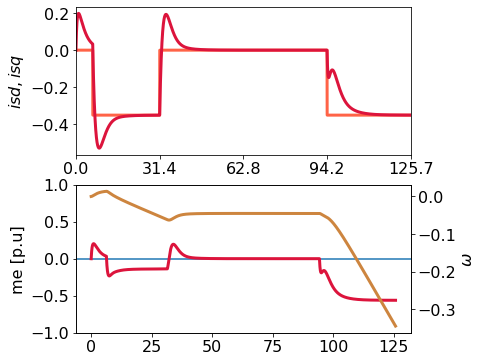

In [83]:
# a = 0.045
ml, a, isq = 0.0, 0.045, -0.35
isdRef1, isqRef1 = calculateIsdIsqRefs(ml, a, isq)
print(isdRef1, isqRef1)
isdRef2, isqRef2 = calculateIsdIsqRefs(ml, 0.0, isqRef1)
print(isdRef2, isqRef2)
isdRef3, isqRef3 = calculateIsdIsqRefs(ml, -a, isqRef2)
print(isdRef3, isqRef3)
# isdRef = np.array([isdRef1, isdRef2, isdRef3])
# isqRef = np.array([isqRef1, isqRef2, isqRef3])
print(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
# Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration(isdRef1, isdRef2, isdRef3, isqRef1, isqRef2, isqRef3)
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration(isdRef1, 0, isdRef3, isqRef1, 0, isqRef3)

print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

In [22]:
# def simulateSpeedingUpWithAcceleration(a):
#     #Setting up the simulaton for rotor model
#     # We will use for loop for simulation 
#     rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
#     tend = 20*2*np.pi
#     tstart = 0.0
#     delta_t = 0.01
#     Tta = np.arange(tstart, tend,delta_t)
#     # ODE solver parameters
#     abserr = 1.0e-8
#     relerr = 1.0e-3
    
#     n = 100000
# #     n2 = int(100*2*np.pi/0.01)
#     # ws = -0.5
#     ws = np.zeros(len(Tta))
#     # Initializing ws:
# #     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
#     mL = 0.0
#     # Tta = np.linspace(tstart, tend, n2)
#     #delta_t = Tta[1] - Tta[0]
#     usd = np.zeros(len(Tta))
#     usq = np.zeros(len(Tta))
#     sol1 = np.zeros((len(Tta),2))
#     # sol2 = np.zeros((len(Tta),2))
#     # FCangle = np.zeros(len(Tta))
#     # Field coordinate currents
#     cosdelta = np.zeros(len(Tta))
#     sindelta = np.zeros(len(Tta))
#     isd = np.zeros(len(Tta))
#     isq = np.zeros(len(Tta))
#     eid = np.zeros(len(Tta))
#     eiq = np.zeros(len(Tta))
#     w = np.zeros(len(Tta))

#     # psird = np.zeros(len(Tta))
#     # psirq = np.zeros(len(Tta))

#     # # Initializing reference values for isd and isq:
#     isdrefval = -0.1
#     isdref = np.zeros(len(Tta))
#     isqref = np.zeros(len(Tta))

#     isqref1 = 0.0
#     isqref2 = 0.8
#     isqref3 = -0.35
#     for ii in range(len(Tta)):
#         isdref[ii] = 0.0
#         if (Tta[ii]>=10*2*np.pi):
#             isqref[ii] = isqref3
#             isdref[ii] = -isdrefval
#         elif(Tta[ii]>=1*2*np.pi):
#             isqref[ii]=isqref2
#             isdref[ii] = isdrefval
#         else:
#             isqref[ii]=isqref1

#     me = np.zeros(len(Tta))
#     x0 = [0,0] # isd, isq, ws
#     y0 = [1.0,0]

#     kpd = ld*1
#     Tid = 25.0e1

#     kpq = lq*2
#     Tiq = 25.0e1

#     Kparamsd = [kpd,Tid]
#     Kparamsq = [kpq,Tiq]

#     for ii in range(len(Tta)):
#         #Start controller after first step
#         if ii>=0:
#             eid[ii] = isdref[ii-1] - isd[ii-1]
#             PIed = [eid[ii],eid[ii-1]]
#             usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
#             eiq[ii] = isqref[ii-1] - isq[ii-1]
#             PIeq = [eiq[ii],eiq[ii-1]]
#             usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

#         # solve for the state variables: isd, isq
#         params = [usd[ii], usq[ii],w[ii], ws[ii]]
#         sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
#         sol1[ii]= sol1a[-1]
#         x0 = sol1a[-1]
#         isd[ii] = sol1[ii][0]
#         isq[ii] = sol1[ii][1]


#     #rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech = mach_para(mach_mb)
#     rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
#     return Tta, ws, me, isd, isq

In [23]:
a = 0.001
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

TypeError: simulateSpeedingUpWithAcceleration() missing 5 required positional arguments: 'isdRef2', 'isdRef3', 'isqRef1', 'isqRef2', and 'isqRef3'

In [ ]:
a = 0.0005
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.0002
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.00015
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.0001
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

In [ ]:
a = 0.00009
Tta, ws, me, isd, isq = simulateSpeedingUpWithAcceleration(a)
plotDynamicForSpeedingUp(Tta, ws, me, isd, isq)

The undershoot of torque decreases significantly when $\omega_s$ is lower than 0.0001. 